### Model to differenciate between muons, electrons and noise

Labels: 0 noise, 1 electron, 2 muon
* [Creating training and validation generators](#Creating-training-and-validation-generators)
* [Model 1: 302 neurons, dropouts, callbacks](#Model-1:-302-neurons,-dropouts,-callbacks)
* [Model 2: 302 neurons, bigger lr](#Model-2:-302-neurons,-bigger-lr)
* [Model 3: 102 neurons](#Model-3:-102-neurons)
* [Model 4: 92 neurons, bigger lr](#Model-4:-92-neurons,-bigger-lr)
* [Model 5: 82 neurons, bigger lr](#Model-5:-82-neurons,-bigger-lr)
* [Eigth model: learning rate modified, 302 neurons](#Eigth-model:-learning-rate-modified,-302-neurons)
* [Ninth model: learning rate modified, 82 neurons](#Ninth-model:-learning-rate-modified,-82-neurons)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.grid(b=False)
    plt.xlim(-0.5, 2.5)
    plt.ylim(2.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [2]:
import keras
from keras import layers, models, optimizers
from keras import callbacks

Using TensorFlow backend.


In [3]:
window_y, window_x = 242,192 #shape of each image

In [4]:
import glob
import os, shutil

### Creating training and validation generators
We need to create a numpy array (X) with the path to each npz file. Each npz contains 64 npy (batch_size), so basically, one npz is one batch. 
* For the training batchs:

In [5]:
path_tr = 'eVSmuVSn_2tr/'
files_tr = os.listdir(path_tr)

X = np.empty(shape=(len(files_tr),), dtype=object)

for index, file in enumerate(files_tr):     
    X[index] = os.path.join(path_tr, files_tr[index]) 

In [6]:
X.shape #we have 103 batchs (npz files) for the training

(157,)

In [7]:
def data_generator2(inputs, shuffle=True):
     while True:
    # Create list of indices
        idxs = np.arange(len(inputs))
        if shuffle:
            np.random.shuffle(idxs)

        for i in idxs:
            batch_X = []

            data = np.load(inputs[i])['X']
            label = np.load(inputs[i])['y']
 
            batch_X.append(data)


            batch_X = np.array(batch_X)
            batch_X = batch_X.reshape((batch_X.shape[1],batch_X.shape[2], batch_X.shape[3], batch_X.shape[4]))
            batch_y = label

            yield batch_X, batch_y

In [8]:
train_gen =  data_generator2(inputs=X) #training data generator

In [9]:
type(train_gen)

generator

* Similary for the validation data:

In [10]:
path_v = 'eVSmuVSn_2val/'
files_v = os.listdir(path_v)

#X is a numpy array of the baths to the npz files, where each one contains a batch of npy
X = np.empty(shape=(len(files_v),), dtype=object)

for index, file in enumerate(files_v):     
    X[index] = os.path.join(path_v, files_v[index]) 

In [11]:
X.shape #this is how many batches we have of validation data

(53,)

In [12]:
val_gen = data_generator2(inputs=X)

### Model 1: 302 neurons, dropouts, callbacks

In [35]:
model_v1 = models.Sequential()
model_v1.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v1.add(layers.MaxPooling2D((2,2)))
model_v1.add(layers.Conv2D(32,(3,3), activation='relu'))
model_v1.add(layers.MaxPooling2D((2,2)))
model_v1.add(layers.Conv2D(32,(3,3), activation='relu'))
model_v1.add(layers.MaxPooling2D((2,2)))
model_v1.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v1.add(layers.MaxPooling2D((2,2)))
model_v1.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v1.add(layers.MaxPooling2D((2,2)))

model_v1.add(layers.Flatten())
model_v1.add(layers.Dropout((0.5)))
model_v1.add(layers.Dense(units= 302, activation='relu'))
model_v1.add(layers.Dropout((0.5)))
model_v1.add(layers.Dense(units= 3, activation='softmax'))
model_v1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 240, 190, 32)      320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 120, 95, 32)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 118, 93, 32)       9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 59, 46, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 57, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 28, 22, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 26, 20, 64)       

In [36]:
model_v1.compile(optimizer=optimizers.RMSprop(lr= 1e-4),loss='categorical_crossentropy', metrics=['acc'])

In [13]:
my_callbacks = [
    callbacks.EarlyStopping(patience=7)
]

In [38]:
historyv1 = model_v1.fit_generator(train_gen, epochs=30, validation_data=val_gen, 
                                   steps_per_epoch= 157, validation_steps= 53, callbacks = my_callbacks)

Epoch 1/30
157/157 [==============================] - 200s 1s/step - loss: 0.9697 - acc: 0.6411 - val_loss: 0.8692 - val_acc: 0.6642
Epoch 2/30
157/157 [==============================] - 199s 1s/step - loss: 0.8639 - acc: 0.6638 - val_loss: 0.7758 - val_acc: 0.6675
Epoch 3/30
157/157 [==============================] - 200s 1s/step - loss: 0.7078 - acc: 0.6769 - val_loss: 0.5883 - val_acc: 0.7235
Epoch 4/30
157/157 [==============================] - 200s 1s/step - loss: 0.5028 - acc: 0.7220 - val_loss: 0.4336 - val_acc: 0.7459
Epoch 5/30
157/157 [==============================] - 199s 1s/step - loss: 0.4216 - acc: 0.7637 - val_loss: 0.4570 - val_acc: 0.7771
Epoch 6/30
157/157 [==============================] - 199s 1s/step - loss: 0.4059 - acc: 0.7740 - val_loss: 0.3886 - val_acc: 0.7871
Epoch 7/30
157/157 [==============================] - 210s 1s/step - loss: 0.3915 - acc: 0.7892 - val_loss: 0.4008 - val_acc: 0.7733
Epoch 8/30
157/157 [==============================] - 202s 1s/step - 

In [39]:
model_v1.save('models/e_mu_n_v1.h5')

* Creating the testing data from the data generator:

In [14]:
path_t = 'eVSmuVSn_2test/'
files_t = os.listdir(path_t)

X = np.empty(shape=(len(files_t),), dtype=object)

for index, file in enumerate(files_t):     
    X[index] = os.path.join(path_t, files_t[index]) 

In [15]:
X.shape

(53,)

In [16]:
test_gen = data_generator2(inputs=X)

Now we can evaluate model to get the accuracy in the test date:

In [43]:
loss, acc = model_v1.evaluate_generator(test_gen, steps=53)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

Accuracy with the model: 84.08%


Finally we predict, to draw the confusion matrix:

In [17]:
def test_generator(inputs, shuffle=True):
    while True:
    # Create list of indices
        idxs = np.arange(len(inputs))
        if shuffle:
            np.random.shuffle(idxs)
        
        list_labels = []
        
        for i in idxs:
            batch_X = []

            data = np.load(inputs[i])['X']
            label = np.load(inputs[i])['y']
            batch_X.append(data)


            batch_X = np.array(batch_X)
            batch_X = batch_X.reshape((batch_X.shape[1],batch_X.shape[2], batch_X.shape[3], batch_X.shape[4]))
            batch_y = label
            list_labels.append(batch_y)
            
            yield batch_X, batch_y
            
        list_labels = np.array(list_labels)
        list_labels.flatten()
        np.save('y_labels' , list_labels)

In [18]:
def gen_true_y():
    true_labels = np.load('y_labels.npy')
    true_labels = true_labels.reshape(true_labels.shape[0]*true_labels.shape[1],3)
    true_labels = np.argmax(true_labels, axis=1)
    
    return true_labels

In [46]:
y_predicted1 = model_v1.predict_generator(test_generator(X), steps=53)

In [47]:
y_predicted1[0:10]

array([[9.9999714e-01, 3.7229444e-08, 2.8039110e-06],
       [9.9999714e-01, 3.8597701e-08, 2.8725235e-06],
       [1.6764382e-08, 4.8274864e-02, 9.5172513e-01],
       [1.2216253e-14, 9.9287838e-01, 7.1215970e-03],
       [9.9999726e-01, 3.7438873e-08, 2.7718027e-06],
       [9.9999726e-01, 3.7075676e-08, 2.7710096e-06],
       [9.4565460e-11, 5.9897583e-02, 9.4010240e-01],
       [5.9509335e-09, 6.8442082e-01, 3.1557921e-01],
       [9.6472030e-09, 8.8635730e-03, 9.9113643e-01],
       [9.9999726e-01, 3.6255525e-08, 2.7355600e-06]], dtype=float32)

In [48]:
y_predicted1 = np.argmax(y_predicted1, axis=1)

In [49]:
y_predicted1[0:10]

array([0, 0, 2, 1, 0, 0, 2, 1, 2, 0])

In [50]:
true_labels = gen_true_y()

In [51]:
true_labels[0:10]

array([0, 0, 2, 1, 0, 0, 2, 1, 1, 0])

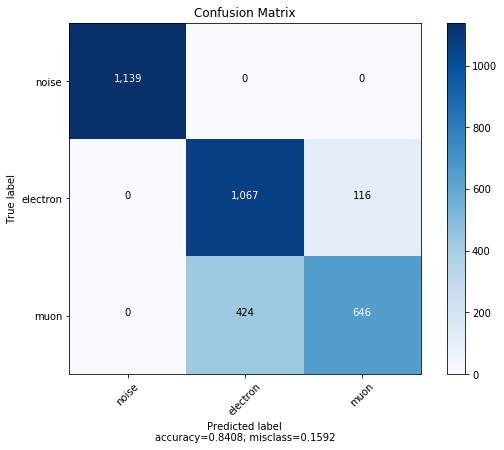

In [52]:
conf1 = confusion_matrix(true_labels, y_predicted1, labels = list([0,1,2]))
plot_confusion_matrix(cm           = conf1, 
                      normalize    = False,
                      target_names = ['noise','electron', 'muon'],
                      title        = "Confusion Matrix")

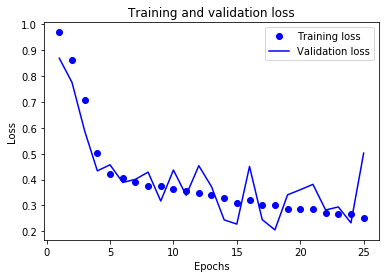

In [53]:
history_n1 = historyv1.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 2: 302 neurons, bigger lr

In [26]:
model_v2 = models.Sequential()
model_v2.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Conv2D(32,(3,3), activation='relu'))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Conv2D(128,(2,2), activation='relu'))
model_v2.add(layers.MaxPooling2D((2,2)))

model_v2.add(layers.Flatten())
model_v2.add(layers.Dropout((0.5)))
model_v2.add(layers.Dense(units= 302, activation='relu'))
model_v2.add(layers.Dropout((0.5)))
model_v2.add(layers.Dense(units= 3, activation='softmax'))
model_v2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 240, 190, 32)      320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 120, 95, 32)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 118, 93, 32)       9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 59, 46, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 57, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 28, 22, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 26, 20, 64)       

In [27]:
model_v2.compile(optimizer=optimizers.RMSprop(lr= 1e-3),loss='categorical_crossentropy', metrics=['acc'])

In [28]:
historyv2 = model_v2.fit_generator(train_gen, epochs=40, validation_data=val_gen, 
                                   steps_per_epoch= 157, validation_steps= 53,callbacks=my_callbacks)

Epoch 1/40
157/157 [==============================] - 216s 1s/step - loss: 0.7013 - acc: 0.6565 - val_loss: 0.3792 - val_acc: 0.7052
Epoch 2/40
157/157 [==============================] - 213s 1s/step - loss: 0.5951 - acc: 0.7235 - val_loss: 0.4045 - val_acc: 0.7733
Epoch 3/40
157/157 [==============================] - 216s 1s/step - loss: 0.4982 - acc: 0.7651 - val_loss: 0.3850 - val_acc: 0.7706
Epoch 4/40
157/157 [==============================] - 231s 1s/step - loss: 0.5219 - acc: 0.7663 - val_loss: 0.4117 - val_acc: 0.7748
Epoch 5/40
157/157 [==============================] - 220s 1s/step - loss: 0.4846 - acc: 0.7851 - val_loss: 0.4024 - val_acc: 0.7960
Epoch 6/40
157/157 [==============================] - 222s 1s/step - loss: 0.4733 - acc: 0.7916 - val_loss: 0.3977 - val_acc: 0.7751
Epoch 7/40
157/157 [==============================] - 210s 1s/step - loss: 0.4460 - acc: 0.8080 - val_loss: 0.9317 - val_acc: 0.7367
Epoch 8/40
157/157 [==============================] - 206s 1s/step - 

In [29]:
model_v2.save('models/e_mu_n_v2.h5')

In [30]:
loss, acc = model_v2.evaluate_generator(test_gen, steps=53)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

Accuracy with the model: 85.32%


In [31]:
y_predicted2 = model_v2.predict_generator(test_generator(X), steps=53)

y_predicted2 = np.argmax(y_predicted2, axis=1)

In [32]:
true_labels = gen_true_y()

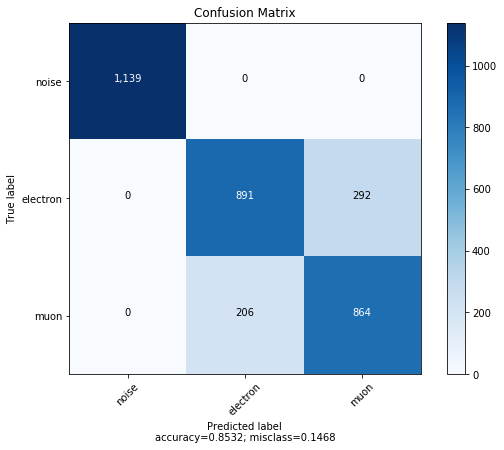

In [33]:
conf2 = confusion_matrix(true_labels, y_predicted2, labels = list([0,1,2]))
plot_confusion_matrix(cm           = conf2, 
                      normalize    = False,
                      target_names = ['noise','electron', 'muon'],
                      title        = "Confusion Matrix")

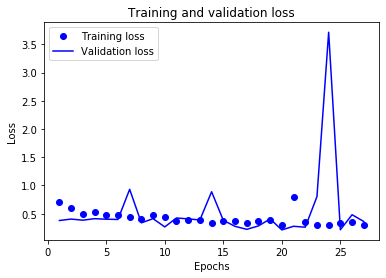

In [34]:
history_n1 = historyv2.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 3: 102 neurons

In [54]:
model_v6 = models.Sequential()
model_v6.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v6.add(layers.MaxPooling2D((2,2)))
model_v6.add(layers.Conv2D(32,(3,3), activation='relu'))
model_v6.add(layers.MaxPooling2D((2,2)))
model_v6.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v6.add(layers.MaxPooling2D((2,2)))
model_v6.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v6.add(layers.MaxPooling2D((2,2)))
model_v6.add(layers.Conv2D(128,(2,2), activation='relu'))
model_v6.add(layers.MaxPooling2D((2,2)))

model_v6.add(layers.Flatten())
model_v6.add(layers.Dropout((0.5)))
model_v6.add(layers.Dense(units= 102, activation='relu'))
model_v6.add(layers.Dropout((0.5)))
model_v6.add(layers.Dense(units= 3, activation='softmax'))
model_v6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 240, 190, 32)      320       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 120, 95, 32)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 118, 93, 32)       9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 59, 46, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 57, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 28, 22, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 26, 20, 64)       

In [55]:
model_v6.compile(optimizer=optimizers.RMSprop(lr= 1e-4),loss='categorical_crossentropy', metrics=['acc'])

In [56]:
historyv6 = model_v6.fit_generator(train_gen, epochs=35, validation_data=val_gen, 
                                   steps_per_epoch= 157, validation_steps= 53,callbacks=my_callbacks)

Epoch 1/35
157/157 [==============================] - 205s 1s/step - loss: 0.9511 - acc: 0.6554 - val_loss: 0.8859 - val_acc: 0.6698
Epoch 2/35
157/157 [==============================] - 204s 1s/step - loss: 0.8371 - acc: 0.6546 - val_loss: 0.7291 - val_acc: 0.6474
Epoch 3/35
157/157 [==============================] - 203s 1s/step - loss: 0.6623 - acc: 0.6640 - val_loss: 0.5255 - val_acc: 0.7205
Epoch 4/35
157/157 [==============================] - 204s 1s/step - loss: 0.4841 - acc: 0.7407 - val_loss: 0.3580 - val_acc: 0.7677
Epoch 5/35
157/157 [==============================] - 203s 1s/step - loss: 0.4255 - acc: 0.7660 - val_loss: 0.4513 - val_acc: 0.7709
Epoch 6/35
157/157 [==============================] - 203s 1s/step - loss: 0.4045 - acc: 0.7748 - val_loss: 0.5236 - val_acc: 0.7642
Epoch 7/35
157/157 [==============================] - 210s 1s/step - loss: 0.3867 - acc: 0.7931 - val_loss: 0.3536 - val_acc: 0.7839
Epoch 8/35
157/157 [==============================] - 225s 1s/step - 

In [57]:
model_v6.save('models/e_mu_n_v3.h5')

In [58]:
loss, acc = model_v6.evaluate_generator(test_gen, steps=53)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

Accuracy with the model: 84.94%


In [59]:
y_predicted6 = model_v6.predict_generator(test_generator(X), steps=53)

y_predicted6 = np.argmax(y_predicted6, axis=1)

true_labels = gen_true_y()

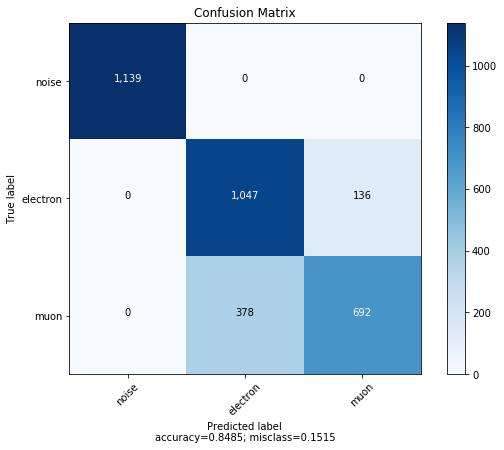

In [60]:
conf6 = confusion_matrix(true_labels, y_predicted6, labels = list([0,1,2]))
plot_confusion_matrix(cm           = conf6, 
                      normalize    = False,
                      target_names = ['noise','electron', 'muon'],
                      title        = "Confusion Matrix")

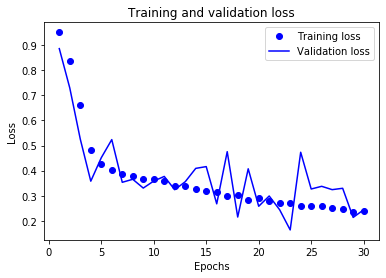

In [61]:
history_n1 = historyv6.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 4: 92 neurons, bigger lr

In [19]:
model_v7 = models.Sequential()
model_v7.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v7.add(layers.MaxPooling2D((2,2)))
model_v7.add(layers.Conv2D(32,(3,3), activation='relu'))
model_v7.add(layers.MaxPooling2D((2,2)))
model_v7.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v7.add(layers.MaxPooling2D((2,2)))
model_v7.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v7.add(layers.MaxPooling2D((2,2)))
model_v7.add(layers.Conv2D(128,(2,2), activation='relu'))
model_v7.add(layers.MaxPooling2D((2,2)))

model_v7.add(layers.Flatten())
model_v7.add(layers.Dropout((0.5)))
model_v7.add(layers.Dense(units= 92, activation='relu'))
model_v7.add(layers.Dropout((0.5)))
model_v7.add(layers.Dense(units= 3, activation='softmax'))
model_v7.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 240, 190, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 120, 95, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 118, 93, 32)       9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 59, 46, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 57, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 22, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 20, 64)       

In [21]:
model_v7.compile(optimizer=optimizers.RMSprop(learning_rate=1e-3),loss='categorical_crossentropy', metrics=['acc'])

In [22]:
historyv7 = model_v7.fit_generator(train_gen, epochs=40, validation_data=val_gen, 
                                   steps_per_epoch= 157, validation_steps= 53,callbacks=my_callbacks)

Epoch 1/40
157/157 [==============================] - 229s 1s/step - loss: 0.7259 - acc: 0.6483 - val_loss: 0.6230 - val_acc: 0.7123
Epoch 2/40
157/157 [==============================] - 213s 1s/step - loss: 0.5910 - acc: 0.7225 - val_loss: 0.4176 - val_acc: 0.7748
Epoch 3/40
157/157 [==============================] - 218s 1s/step - loss: 0.4913 - acc: 0.7540 - val_loss: 0.4888 - val_acc: 0.7795
Epoch 4/40
157/157 [==============================] - 214s 1s/step - loss: 0.4715 - acc: 0.7778 - val_loss: 0.4089 - val_acc: 0.7718
Epoch 5/40
157/157 [==============================] - 213s 1s/step - loss: 0.5112 - acc: 0.7753 - val_loss: 0.4656 - val_acc: 0.8042
Epoch 6/40
157/157 [==============================] - 209s 1s/step - loss: 0.4503 - acc: 0.7904 - val_loss: 0.5262 - val_acc: 0.7612
Epoch 7/40
157/157 [==============================] - 209s 1s/step - loss: 0.4907 - acc: 0.7865 - val_loss: 0.5555 - val_acc: 0.7845
Epoch 8/40
157/157 [==============================] - 215s 1s/step - 

In [23]:
model_v7.save('models/e_mu_n_v4.h5')

In [24]:
loss, acc = model_v7.evaluate_generator(test_gen, steps=53)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

Accuracy with the model: 86.20%


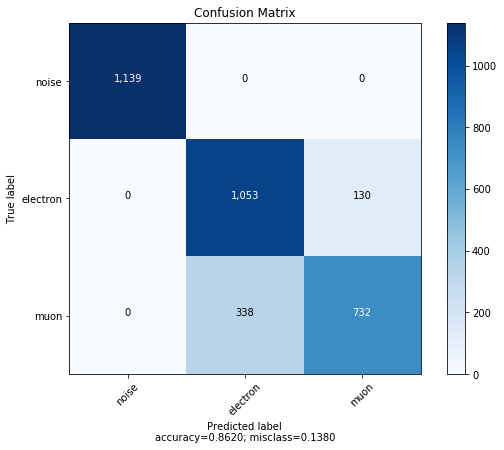

In [25]:
y_predicted7 = model_v7.predict_generator(test_generator(X), steps=53)

y_predicted7 = np.argmax(y_predicted7, axis=1)

true_labels = gen_true_y()

conf7 = confusion_matrix(true_labels, y_predicted7, labels = list([0,1,2]))
plot_confusion_matrix(cm           = conf7, 
                      normalize    = False,
                      target_names = ['noise','electron', 'muon'],
                      title        = "Confusion Matrix")

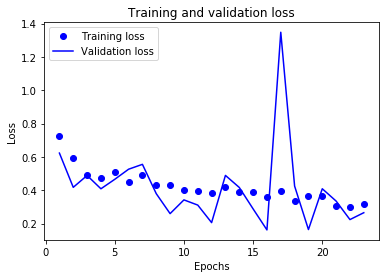

In [26]:
history_n1 = historyv7.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 5: 82 neurons, bigger lr

In [27]:
model_v9 = models.Sequential()
model_v9.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v9.add(layers.MaxPooling2D((2,2)))
model_v9.add(layers.Conv2D(32,(3,3), activation='relu'))
model_v9.add(layers.MaxPooling2D((2,2)))
model_v9.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v9.add(layers.MaxPooling2D((2,2)))
model_v9.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v9.add(layers.MaxPooling2D((2,2)))
model_v9.add(layers.Conv2D(128,(2,2), activation='relu'))
model_v9.add(layers.MaxPooling2D((2,2)))

model_v9.add(layers.Flatten())
model_v9.add(layers.Dropout((0.5)))
model_v9.add(layers.Dense(units= 82, activation='relu'))
model_v9.add(layers.Dropout((0.5)))
model_v9.add(layers.Dense(units= 3, activation='softmax'))
model_v9.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 240, 190, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 120, 95, 32)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 118, 93, 32)       9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 59, 46, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 57, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 22, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 20, 64)       

In [28]:
model_v9.compile(optimizer=optimizers.RMSprop(lr= 1e-3),loss='categorical_crossentropy', metrics=['acc'])

In [29]:
historyv9 = model_v9.fit_generator(train_gen, epochs=35, validation_data=val_gen, 
                                   steps_per_epoch= 157, validation_steps= 53,callbacks=my_callbacks)

Epoch 1/35
157/157 [==============================] - 247s 2s/step - loss: 0.7486 - acc: 0.6395 - val_loss: 0.4430 - val_acc: 0.7485
Epoch 2/35
157/157 [==============================] - 246s 2s/step - loss: 0.5781 - acc: 0.7212 - val_loss: 0.4888 - val_acc: 0.7553
Epoch 3/35
157/157 [==============================] - 219s 1s/step - loss: 0.5286 - acc: 0.7568 - val_loss: 0.3987 - val_acc: 0.7653
Epoch 4/35
157/157 [==============================] - 213s 1s/step - loss: 0.4817 - acc: 0.7775 - val_loss: 0.4594 - val_acc: 0.7650
Epoch 5/35
157/157 [==============================] - 212s 1s/step - loss: 0.4429 - acc: 0.7844 - val_loss: 0.3317 - val_acc: 0.7866
Epoch 6/35
157/157 [==============================] - 209s 1s/step - loss: 0.5039 - acc: 0.8022 - val_loss: 0.3185 - val_acc: 0.7615
Epoch 7/35
157/157 [==============================] - 209s 1s/step - loss: 0.4695 - acc: 0.7891 - val_loss: 0.6429 - val_acc: 0.8051
Epoch 8/35
157/157 [==============================] - 212s 1s/step - 

In [30]:
model_v9.save('models/e_mu_n_v5.h5')

In [31]:
loss, acc = model_v9.evaluate_generator(test_gen, steps=53)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

Accuracy with the model: 87.56%


In [34]:
y_predicted9 = model_v9.predict_generator(test_generator(X), steps=53)

y_predicted9 = np.argmax(y_predicted9, axis=1)

true_labels = gen_true_y()

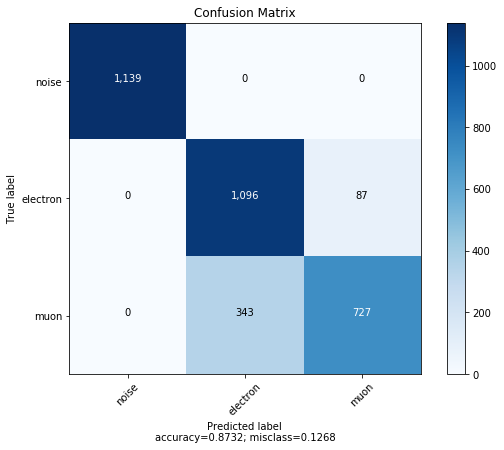

In [35]:
conf9 = confusion_matrix(true_labels, y_predicted9, labels = list([0,1,2]))
plot_confusion_matrix(cm           = conf9, 
                      normalize    = False,
                      target_names = ['noise','electron', 'muon'],
                      title        = "Confusion Matrix")

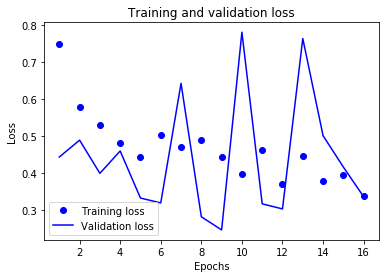

In [36]:
history_n1 = historyv9.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Checking electrons mistaken in the model with best accuracy (model 6)

In [22]:
loaded_model = models.load_model("model_electron_or_muon_v6.h5")
 
# evaluate loaded model on test data
loaded_model.compile(optimizer=optimizers.RMSprop(lr= 1e-3),loss='binary_crossentropy', metrics=['acc'])

In [50]:
def test_generator_XY(inputs, shuffle=True):
    while True:
    # Create list of indices
        idxs = np.arange(len(inputs))
        if shuffle:
            np.random.shuffle(idxs)
        
        list_labels = []
        distributionX = []
        
        for i in idxs:
            batch_X = []

            data = np.load(inputs[i])['X']
            label = np.load(inputs[i])['y']
            label = label.reshape(label.shape[0])
            batch_X.append(data)


            batch_X = np.array(batch_X)
            
            batch_X = batch_X.reshape((batch_X.shape[1],batch_X.shape[2], batch_X.shape[3], batch_X.shape[4]))
            batch_y = label
            list_labels.append(batch_y)
            
            aux = batch_X.reshape((batch_X.shape[0],batch_X.shape[1], batch_X.shape[2]))
            distributionX.append(aux.sum(axis=1).sum(axis=1))
            
            yield batch_X, batch_y
            
        list_labels = np.array(list_labels)
        list_labels.flatten()

        distributionX = np.array(distributionX)
        distributionX.flatten()
        
        np.save('energy_distribution', distributionX)
        np.save('y_labels' , list_labels)

In [51]:
y_pred = loaded_model.predict_generator(test_generator_XY(X), steps=35)

y_pred[np.where(y_pred>=0.5)] = 1
y_pred[np.where(y_pred<0.5)] = 0

true_labels = gen_true_y() #true labels

In [52]:
Xsums = np.load('energy_distribution.npy')

In [53]:
Xsums.shape

(35, 64)

In [54]:
true_labels.shape

(2240, 1)

In [55]:
Xsums = Xsums.reshape(Xsums.shape[0] * Xsums.shape[1],1)

Xsums.shape #sum of the energy for each image

(2240, 1)

Adding the true labels to the energy data:

In [56]:
X_y_true = np.concatenate((Xsums, true_labels),axis=1)

X_y_true.shape

(2240, 2)

In [57]:
X_y_true[0] #electron with total standarized energy 10^3

array([-735.0559793,    1.       ])

Adding the predicted labels to the array created:

In [58]:
X_true_predicted = np.concatenate((Xsums, true_labels, y_pred),axis=1)

In [59]:
X_true_predicted[0] #electron with energy 10^3, classified as electron

array([-735.0559793,    1.       ,    1.       ])

In [60]:
X_true_predicted[10] #electron with standarized energy -826, classified as electron

array([-401.37776077,    1.        ,    1.        ])

Histagram of energy:

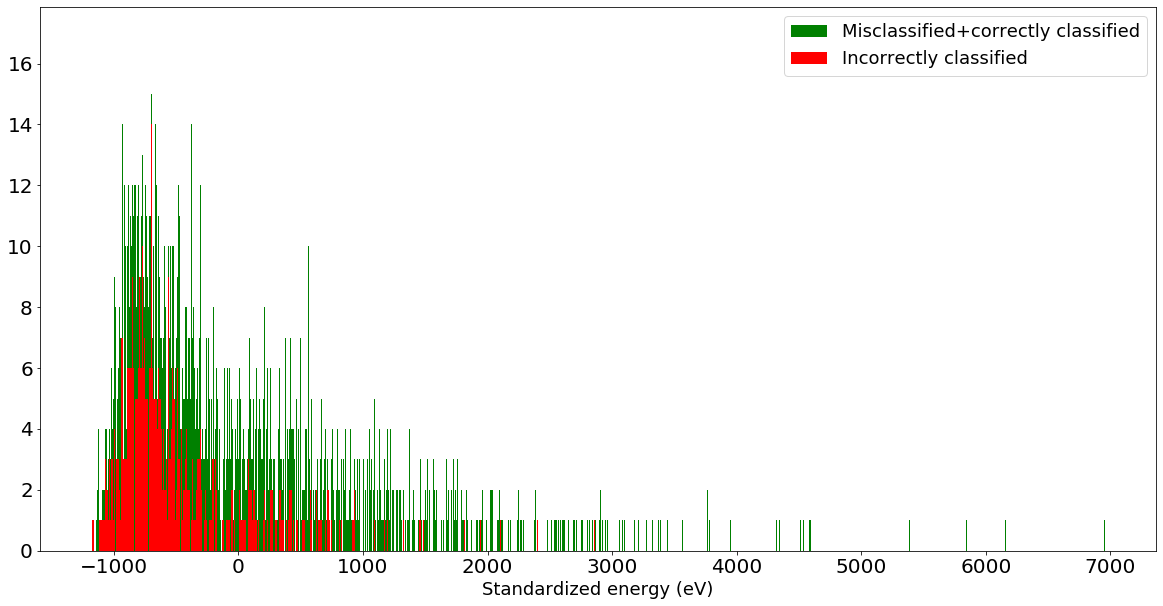

In [61]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

values =  X_true_predicted[:,0]
plt1 = n, bins, patches = plt.hist(values, bins=1500,
                            align='left', color='g')

values_non_true = np.where(X_true_predicted[:,1] != X_true_predicted[:,2])
values_non_true = X_true_predicted[values_non_true,0]
values_non_true = np.rollaxis(values_non_true, -1)


plt2 = n, bins, patches = plt.hist(values_non_true, bins=len(values_non_true),
                            align='left', color='r')
plt.legend(('Misclassified+correctly classified', 'Incorrectly classified'), fontsize=18)
plt.xlabel('Standardized energy (eV)', fontsize=18)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
plt.show()

In [62]:
len(values)

2240

In [63]:
len(values_non_true)

398

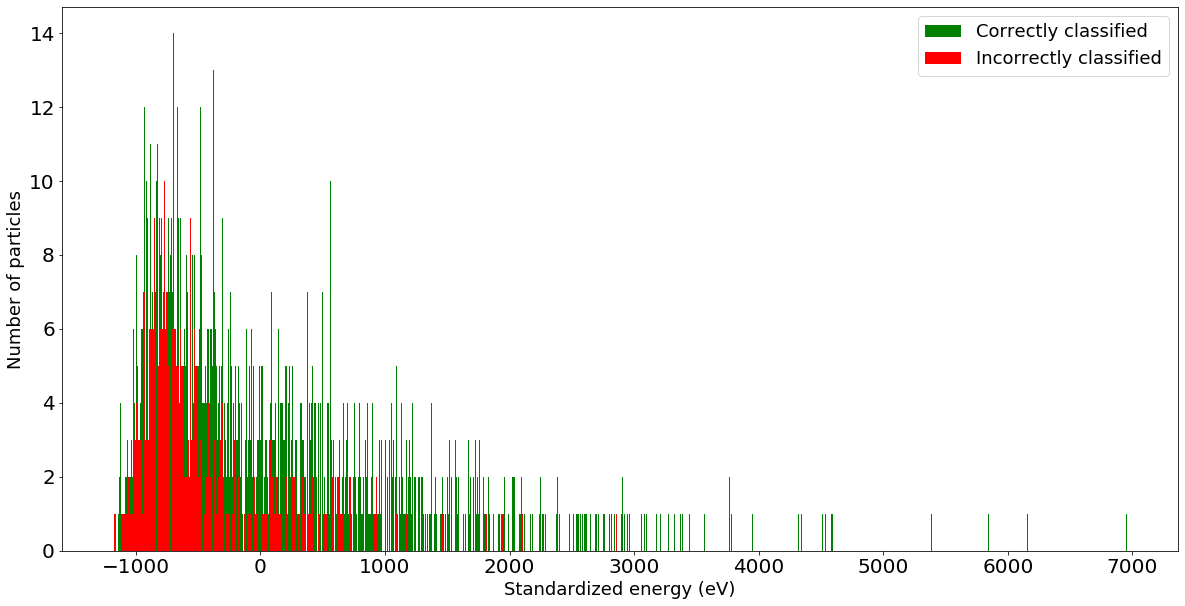

In [65]:
plt.figure(figsize=(20,10))

values =  X_true_predicted[:,0]

values_true = np.where(X_true_predicted[:,1] == X_true_predicted[:,2])
values_true = X_true_predicted[values_true,0]
values_true = np.rollaxis(values_true, -1)

plt1 = n, bins, patches = plt.hist(values_true, bins=1500,
                            align='left', color='g')

values_non_true = np.where(X_true_predicted[:,1] != X_true_predicted[:,2])
values_non_true = X_true_predicted[values_non_true,0]
values_non_true = np.rollaxis(values_non_true, -1)


plt2 = n, bins, patches = plt.hist(values_non_true, bins=len(values_non_true),
                            align='left', color='r')
plt.legend(('Correctly classified', 'Incorrectly classified'), fontsize=18)
plt.xlabel('Standardized energy (eV)', fontsize=18)
plt.ylabel('Number of particles', fontsize=18)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
plt.show()

### Plotting mistaken tracks

In [23]:
def test_generator_XY2(inputs, shuffle=True):
    while True:
    # Create list of indices
        idxs = np.arange(len(inputs))

        if shuffle:
            np.random.shuffle(idxs)
        
        list_labels = []
        distributionX = []
        
        for i in idxs:
            batch_X = []

            data = np.load(inputs[i])['X']
            label = np.load(inputs[i])['y']
            label = label.reshape(label.shape[0])
            batch_X.append(data)


            batch_X = np.array(batch_X)
            batch_X = batch_X.reshape((batch_X.shape[1],batch_X.shape[2], batch_X.shape[3], batch_X.shape[4]))

            batch_y = label
            
            list_labels.append(batch_y)
            distributionX.append(batch_X)
            
            yield batch_X, batch_y
            
        list_labels = np.array(list_labels)
        list_labels.flatten()

        distributionX = np.array(distributionX)
        distributionX.flatten()
        
        np.save('energy_distribution', distributionX)
        np.save('y_labels' , list_labels)

In [24]:
y_pred2 = loaded_model.predict_generator(test_generator_XY2(X), steps=35)

y_pred2[np.where(y_pred2>=0.5)] = 1
y_pred2[np.where(y_pred2<0.5)] = 0

true_labels2 = gen_true_y() #true labels

In [25]:
X_energy = np.load('energy_distribution.npy')
X_energy.shape

(35, 64, 242, 192, 1)

In [26]:
#deleting last dimension
X_energy = X_energy.reshape(X_energy.shape[0], X_energy.shape[1], X_energy.shape[2], X_energy.shape[3]) 

In [27]:
X_energy =  X_energy.reshape(X_energy.shape[0] * X_energy.shape[1], X_energy.shape[2], X_energy.shape[3])

X_energy.shape

(2240, 242, 192)

Now that we have all the test energy stored in `X_energy`, we will plot this energy in case the particle was misclassified. So first we will put inside this array the labels (both true and predicted) to check whether the particle was correctly classified or not. 

In [28]:
true_predic = np.concatenate((true_labels2, y_pred2),axis=1) #adding predicted labels to true labels

true_predic.shape

(2240, 2)

In [29]:
ind_misclass = np.where(true_predic[:,0] != true_predic[:,1])
misclass = X_energy[ind_misclass]

In [30]:
misclass.shape

(398, 242, 192)

In [38]:
misclass_labels = true_predic[np.where(true_predic[:,0] != true_predic[:,1])] #labels

misclass_labels[0:5]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

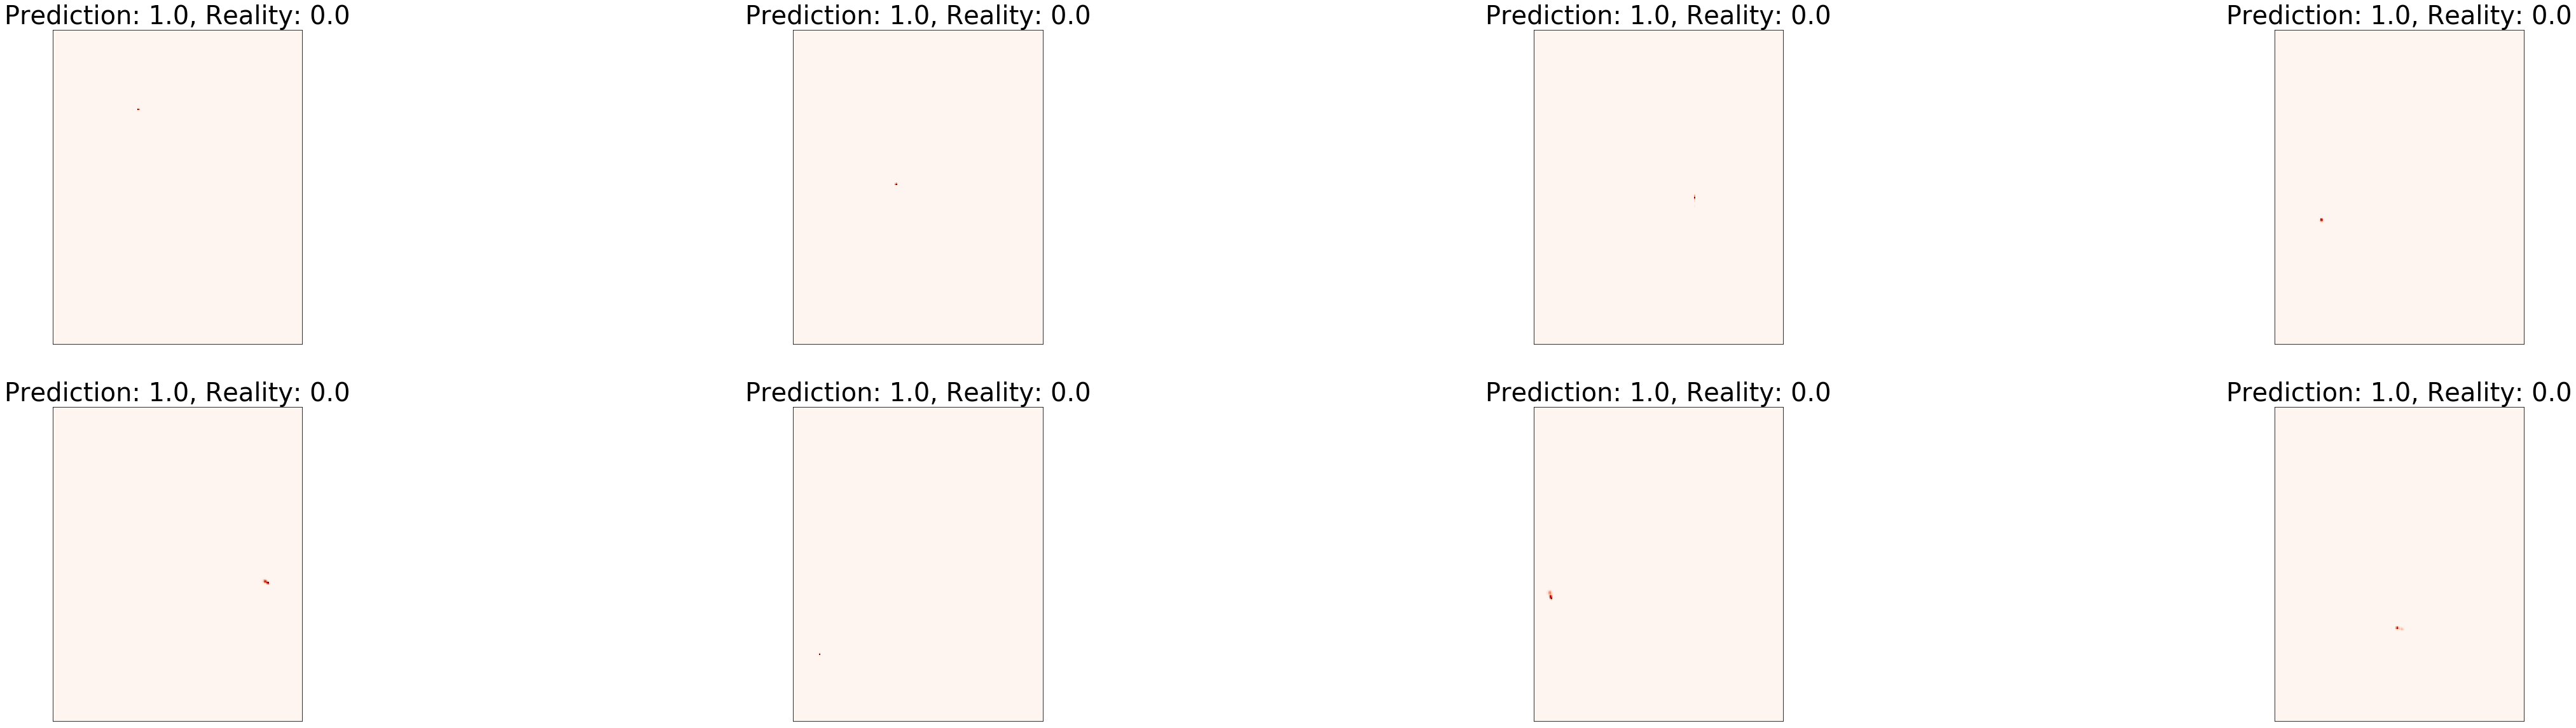

In [47]:
n = 4  # number of images to display

plt.figure(figsize=(80, 20))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(misclass[i], cmap='Reds')
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Prediction: {}, Reality: {}'.format(misclass_labels[i,1], misclass_labels[i,0]), fontsize=40)
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(misclass[i+n], cmap='Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Prediction: {}, Reality: {}'.format(misclass_labels[i+n,1], misclass_labels[i+n,0]), fontsize=40)
    
    
    
plt.show()

### Plotting elongation distribution

For each energy image, we will get the number of pixels regarding the size of the track. The size of the track will be placed, generally, in a rectangle, and the number of pixels associated will be size_x * size_y of this rectangle. Then we will plot the distribution to see if the size of the track is a variable that could confuse the model and lead to an incorrect classification of the particle.

In [18]:
def count_pixels(array):
    
    n_pixels = []
    
    for i in range(array.shape[0]):

        coords = np.argwhere(array[i]>0)
        x_min, y_min = coords.min(axis=0)
        x_max, y_max = coords.max(axis=0)
        n_pixels.append((y_max-y_min+1)*(x_max-x_min+1))

    return n_pixels

In [19]:
def test_generator_XY_pixels(inputs, shuffle=True):
    while True:
    # Create list of indices
        idxs = np.arange(len(inputs))

        if shuffle:
            np.random.shuffle(idxs)
        
        list_labels = []
        list_num_pix = []
        
        for i in idxs:
            batch_X = []

            data = np.load(inputs[i])['X']
            label = np.load(inputs[i])['y']
            label = label.reshape(label.shape[0])
            batch_X.append(data)


            batch_X = np.array(batch_X)
            
            batch_X = batch_X.reshape((batch_X.shape[1],batch_X.shape[2], batch_X.shape[3], batch_X.shape[4]))
            batch_y = label
            list_labels.append(batch_y)
            
            aux = batch_X.reshape((batch_X.shape[0],batch_X.shape[1], batch_X.shape[2]))
            
            pix = count_pixels(aux)
            #print(pix)
            list_num_pix.append(pix)
            
            yield batch_X, batch_y
            
        list_labels = np.array(list_labels)
        list_labels.flatten()

        list_num_pix = np.array(list_num_pix)
        list_num_pix.flatten()
        
        np.save('pixels_distribution', list_num_pix)
        np.save('y_labels' , list_labels)

In [20]:
loaded_model = models.load_model("model_electron_or_muon_v6.h5")
 
# evaluate loaded model on test data
loaded_model.compile(optimizer=optimizers.RMSprop(lr= 1e-3),loss='binary_crossentropy', metrics=['acc'])

In [21]:
y_predi = loaded_model.predict_generator(test_generator_XY_pixels(X), steps=35)

y_predi[np.where(y_predi>=0.5)] = 1
y_predi[np.where(y_predi<0.5)] = 0

true_labels = gen_true_y() #true labels

In [22]:
num_pix = np.load('pixels_distribution.npy')

In [23]:
num_pix.shape

(35, 64)

In [24]:
num_pix

array([[  16,   64,   12, ...,   64,  245, 1872],
       [ 656,   42,   25, ...,   98,  693,   55],
       [ 168,   16, 1224, ...,  192, 1457, 2000],
       ...,
       [  42,   49,    6, ...,  868,  380,   35],
       [ 918,   12,  806, ...,   54,   21,   15],
       [ 396,  112,   20, ..., 1974,  150,  360]])

In [25]:
num_pix = num_pix.reshape((num_pix.shape[0] * num_pix.shape[1],1))

In [26]:
num_pix.shape

(2240, 1)

In [27]:
num_pix

array([[  16],
       [  64],
       [  12],
       ...,
       [1974],
       [ 150],
       [ 360]])

Once we finally got the number of pixels of the track for each test image, we will put inside this `num_pix` array the true and predicted labels to plot the histogram:

In [28]:
Xy_true = np.concatenate((num_pix, true_labels),axis=1) #adding true labels

Xy_true.shape

(2240, 2)

In [29]:
X_true_pred = np.concatenate((num_pix, true_labels, y_predi),axis=1) #adding predicted labels

X_true_pred.shape

(2240, 3)

Histogram for the elongation distribution:

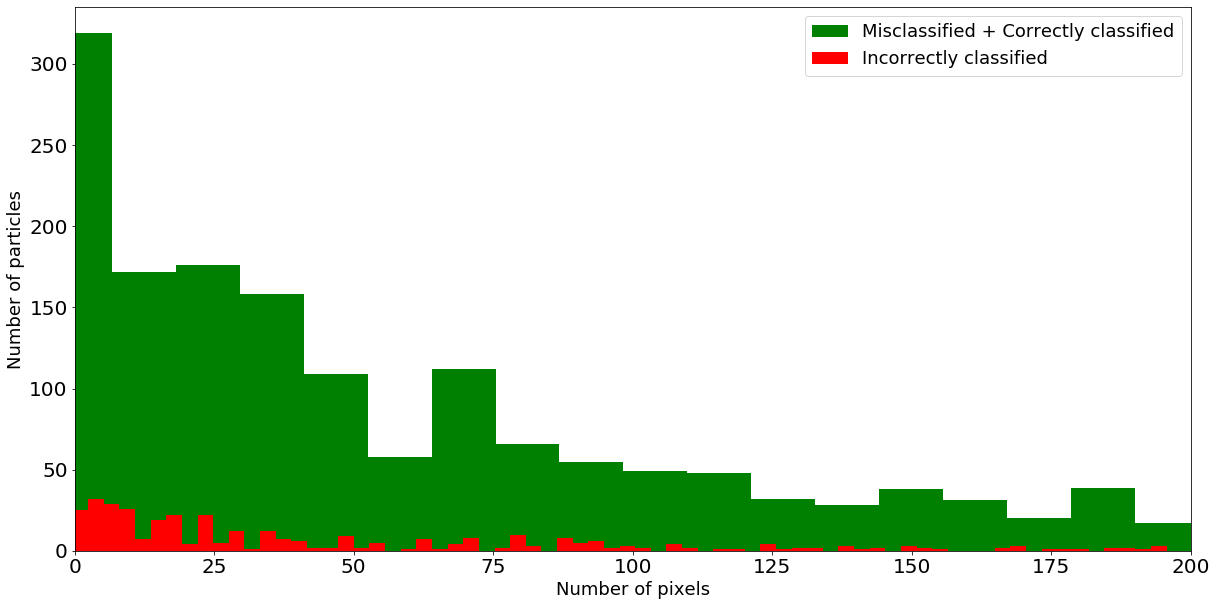

In [30]:
plt.figure(figsize=(20,10))

values =  X_true_pred[:,0]
plt1 = n, bins, patches = plt.hist(values, bins=len(values),
                            align='left', color='g')

values_non_true = np.where(X_true_pred[:,1] != X_true_pred[:,2])
values_non_true = X_true_pred[values_non_true,0]
values_non_true = np.rollaxis(values_non_true, -1)


plt2 = n, bins, patches = plt.hist(values_non_true, bins=len(values_non_true),
                            align='left', color='r')
plt.legend(('Misclassified + Correctly classified', 'Incorrectly classified'), fontsize=18)
plt.xlabel('Number of pixels', fontsize=18)
plt.ylabel('Number of particles', fontsize=18)
plt.xlim(0,200)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
plt.show()

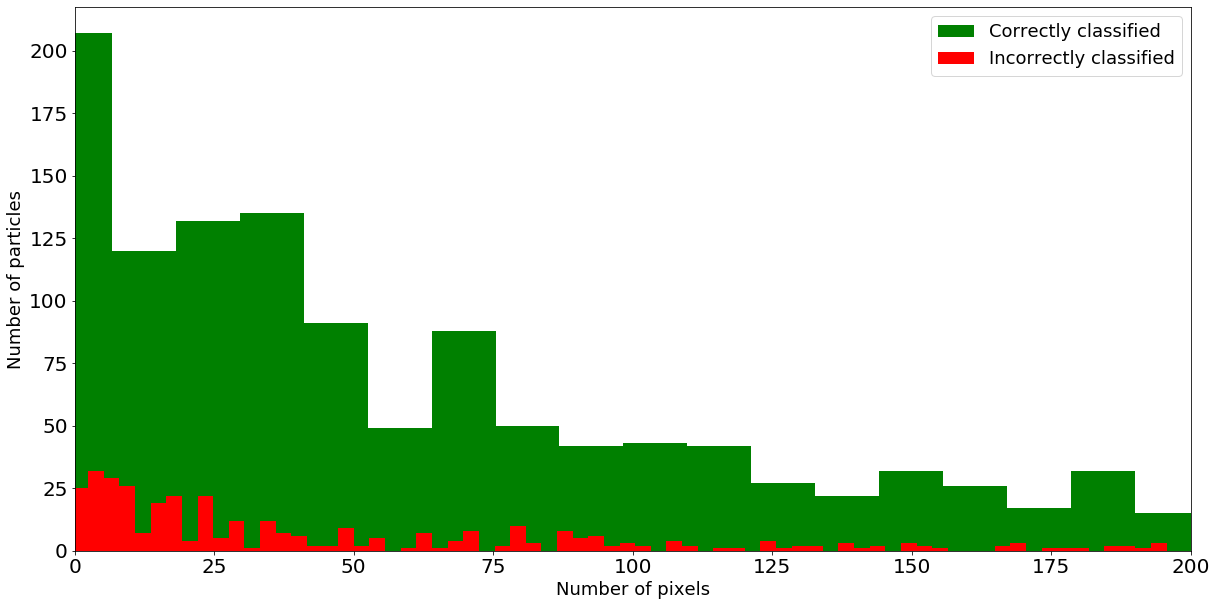

In [31]:
plt.figure(figsize=(20,10))

values =  X_true_pred[:,0]

values_true = np.where(X_true_pred[:,1] == X_true_pred[:,2])
values_true = X_true_pred[values_true,0]
values_true = np.rollaxis(values_true, -1)

plt1 = n, bins, patches = plt.hist(values_true, bins=len(values),
                            align='left', color='g')

values_non_true = np.where(X_true_pred[:,1] != X_true_pred[:,2])
values_non_true = X_true_pred[values_non_true,0]
values_non_true = np.rollaxis(values_non_true, -1)


plt2 = n, bins, patches = plt.hist(values_non_true, bins=len(values_non_true),
                            align='left', color='r')
plt.legend(('Correctly classified', 'Incorrectly classified'), fontsize=18)
plt.xlabel('Number of pixels', fontsize=18)
plt.ylabel('Number of particles', fontsize=18)
plt.xlim(0,200)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
plt.show()

Now we will plot the error rate defined as N(misclassified)/N(correctly classified) 

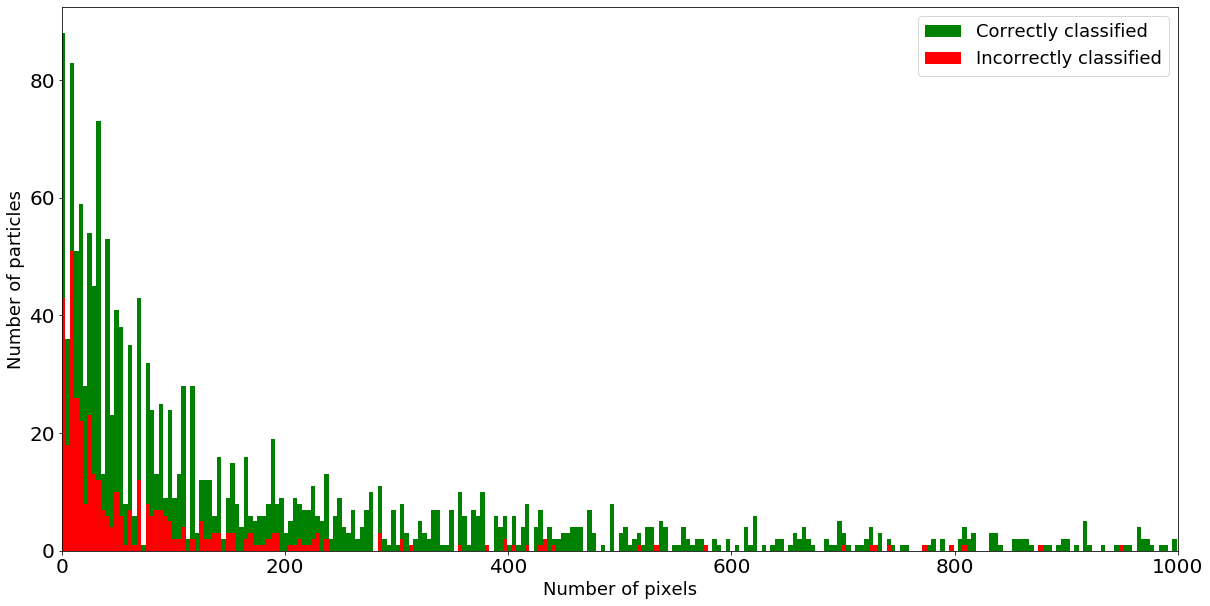

In [32]:
plt.figure(figsize=(20,10))

binwidth =4

values_true = np.where(X_true_pred[:,1] == X_true_pred[:,2])
values_true = X_true_pred[values_true,0]
values_true = np.rollaxis(values_true, -1)

values_non_true = np.where(X_true_pred[:,1] != X_true_pred[:,2])
values_non_true = X_true_pred[values_non_true,0]
values_non_true = np.rollaxis(values_non_true, -1)

bins=np.arange(min(values_true), max(values_true) + binwidth, binwidth)

plt1 = n1, bins1, patches1 = plt.hist(values_true, bins=bins,
                            align='left', color='g')
plt2 = n2, bins2, patches2 = plt.hist(values_non_true, bins=bins,
                            align='left', color='r')
plt.legend(('Correctly classified', 'Incorrectly classified'), fontsize=18)
plt.xlabel('Number of pixels', fontsize=18)
plt.ylabel('Number of particles', fontsize=18)
plt.xlim(0,1000)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
plt.show()

In [33]:
len(n1)

6413

In [34]:
len(n2)

6413

In [35]:
len(np.arange(min(values_true), max(values_true) + binwidth, binwidth))

6414

If we divide n2/n1, we will get the rate error

In [36]:
rate_error = (n2/n1)*100

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [37]:
n1 = np.asarray(n1).flatten()

In [38]:
len(n1)

6413

In [39]:
n1

array([88., 36., 83., ...,  0.,  0.,  1.])

In [40]:
len(np.argwhere(n1==0))

6072

In [41]:
rate_error

array([48.86363636, 50.        , 61.44578313, ...,         nan,
               nan,  0.        ])

In [67]:
len(rate_error)

6413

(array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225.]),
 <a list of 10 Text yticklabel objects>)

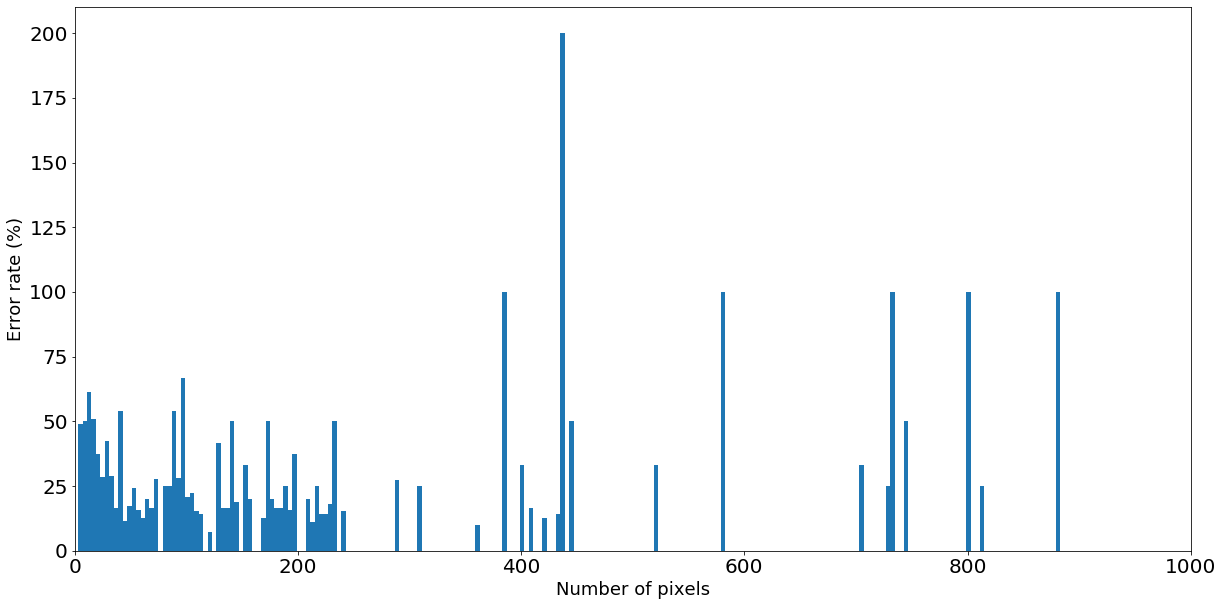

In [68]:
plt.figure(figsize=(20,10))

plt.bar(bins[1:], height = rate_error, width=4)
plt.xlabel('Number of pixels', fontsize=18)
plt.ylabel('Error rate (%)', fontsize=18)
plt.xlim(0,1000)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)

(array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225.]),
 <a list of 10 Text yticklabel objects>)

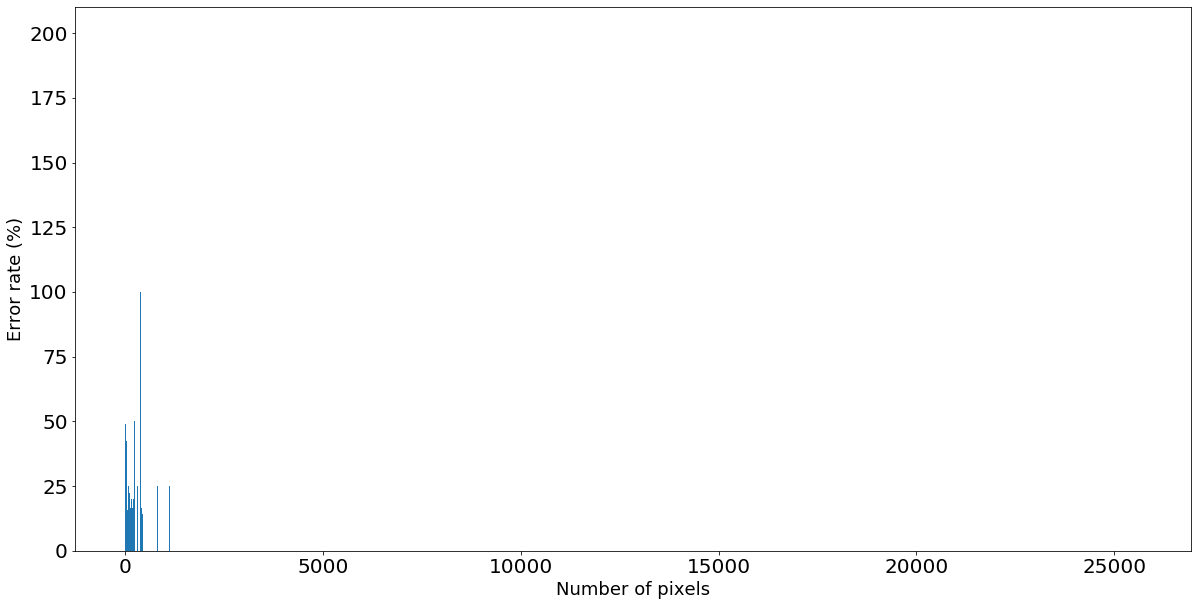

In [43]:
plt.figure(figsize=(20,10))

plt.bar(bins[1:], height = rate_error, width=4)
plt.xlabel('Number of pixels', fontsize=18)
plt.ylabel('Error rate (%)', fontsize=18)
#plt.xlim(0,1000)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)

The bin width is 4, so from 0 to 2000 number of pixels, there are 500 bins. If we wanna check the maximum error rate value, we gotta pick bins from n1 and n2 around the index 100. 

In [80]:
n1[108] #correctly classified

1.0

In [81]:
n2[108] #misclassified

2.0

we look for the maximum of the maximum rate around indices 75 (300/4) and 125 (500/4)

In [79]:
rate_error[108]

200.0